# Example 14 Electron and nuclear spin mixed state dynamics with [RadicalPy](https://github.com/Spin-Chemistry-Labs/radicalpy)

In this tutorial, one constructs MPO of radical pair system (two electron spins and a couple of nuclear spins under magnetic field) by using RadicalPy library.

Import required modules

In [1]:
try:
    import radicalpy
except ModuleNotFoundError:
    # remove uv if you are not using uv
    !uv pip install radicalpy --quiet

!uv pip show radicalpy

import pytdscf

pytdscf.__version__

Using Python 3.12.2 environment at /Users/hinom/GitHub/PyTDSCF/.venv
Name: radicalpy
Version: 1.0.9
Location: /Users/hinom/GitHub/PyTDSCF/.venv/lib/python3.12/site-packages
Requires: dot2tex, graphviz, importlib-resources, matplotlib, mdanalysis, numpy, pint, rdkit, scikit-learn, scipy, seaborn, sympy, tqdm
Required-by:


'1.3.1'

In [2]:
from math import isqrt

import matplotlib.pyplot as plt
import numpy as np
import radicalpy as rp
from IPython.display import HTML
from pympo import (
    AssignManager,
    OpSite,
    SumOfProducts,
)
from radicalpy.simulation import State
from sympy import Symbol

from pytdscf import Exciton, Model, Simulator, units
from pytdscf.util import get_anim, read_nc

## Vectorisation of density matrix

Density matrix $\rho \in \mathbb{C}^{d \times d}$ can be "vectorised" as

$$
|\rho\rangle\rangle := \mathrm{vec}(\rho) \in \mathbb{C}^{d^2}
$$

where 
$$
\mathrm{vec}(\rho) = \begin{pmatrix}
\rho_{11} \\
\rho_{21} \\
\vdots \\
\rho_{d1} \\
\rho_{12} \\
\vdots \\
\rho_{dd}
\end{pmatrix}
$$

Thus, one-dimensional index (in the sense of column-major order, density matrix: ket->bra) is defined as
$$
(ji) := (j-1)d + i
$$
and 
$$
[\mathrm{vec}(\rho)]_{(ji)} = \rho_{ij}
$$

If one adopt basis $\{|i\rangle\}$,
$$
|i\rangle\langle j| \to |i\rangle \otimes |j\rangle = |ij\rangle\rangle.
$$

Now, dual operation $A\rho B^\dagger$ can be vectorised as
$$
\mathrm{vec}(A\rho B^\dagger) = (B^\ast \otimes A) \mathrm{vec}(\rho)
$$

**Proof**
> $$[A\rho B^\dagger]_{ij} = \sum_{k,l} A_{ik} \rho_{kl} B^\ast_{jl}$$
> $$\therefore \mathrm{vec}(A\rho B^\dagger)_{(ji)} = \sum_{k,l} (B_{jl}^\ast A_{ik}) \rho_{kl} = \{(B^\ast \otimes A) \mathrm{vec}(\rho) \}_{(ji)} $$



## Vectorisation of the von Neumann equation

von Neumann equation is
$$
i\hbar \frac{d}{dt} \rho = [H, \rho] = H\rho I^\dagger - I\rho H^\dagger \; (\because H=H^\dagger, I = I^\dagger)
$$
Thus, its vectorised form is
$$
i\hbar \frac{d}{dt} |\rho\rangle\rangle = (I \otimes H - H^\ast \otimes I) |\rho\rangle\rangle
$$



.. note::
   Since the density matrix is approximated by MPS, there are no guarantee that $\rho = \rho^\dagger$ (Hermitian), $\rho_{ii} \geq 0$ (positive semi-definite) and $\mathrm{Tr}(\rho) = 1$ (normalized).


## Total Hamiltonian
$$
\hat{H}_{\text{total}} =
\hat{H}_{\text{Z}} + \hat{H}_{\text{H}} + \hat{H}_{\text{J}} + \hat{H}_{\text{D}}    
$$

## Define systems

In [3]:
is_small_case = True

if is_small_case:
    # You can use following block instead
    n_nuc_spins = 1

    flavin = rp.simulation.Molecule.fromisotopes(
        isotopes=["1H"] * n_nuc_spins, hfcs=[0.4] * n_nuc_spins
    )
    Z = rp.simulation.Molecule.fromisotopes(
        isotopes=["14N"] * n_nuc_spins, hfcs=[0.5] * n_nuc_spins
    )
    sim = rp.simulation.LiouvilleSimulation([flavin, Z])

    # Parameters
    A = {}  # mT
    isotropic = True

    # Isotropic
    for i in range(len(sim.radicals)):
        for j, nuc in enumerate(sim.molecules[i].nuclei):
            if isotropic:
                A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
            else:
                A[(i, j)] = nuc.hfc.anisotropic
    B0 = 0.2  # 2J
    B = np.array((0.0, 0.0, 1.0)) * B0  # mT
    J = 0.1  # Typically 1.0e+03 scale # mT
    D = -0.1  # mT
    kS = 1.0e06  # Exponential model in s-1
    kT = 1.0e06
    if isinstance(D, float):
        assert D <= 0
        D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D
else:
    flavin = rp.simulation.Molecule.all_nuclei("flavin_anion")
    trp = rp.simulation.Molecule.all_nuclei("tryptophan_cation")
    sim = rp.simulation.LiouvilleSimulation([flavin, trp])
    A = {}
    isotropic = False
    for i in range(len(sim.radicals)):
        for j, nuc in enumerate(sim.molecules[i].nuclei):
            if isotropic:
                A[(i, j)] = np.eye(3) * nuc.hfc.isotropic
            else:
                A[(i, j)] = nuc.hfc.anisotropic
    B0 = 2.0  # Typically 0.01 mT~10 mT
    B = np.array((0.0, 0.0, 1.0)) * B0
    J = 0.1  # Typically 1.0e+03 scale
    D = -0.1
    kS = 1.0e06  # Exponential model in s-1
    kT = 1.0e06
    if isinstance(D, float):
        assert D <= 0
        D = 2 / 3 * np.diag((-1.0, -1.0, 2.0)) * D
sim

Number of electrons: 2
Number of nuclei: 2
Number of particles: 4
Multiplicities: [2, 2, 2, 3]
Magnetogyric ratios (mT): [-176085963.023, -176085963.023, 267522.18744, 19337.792]
Nuclei: [1H(267522187.44, 2, 0.4 <anisotropic not available>), 14N(19337792.0, 3, 0.5 <anisotropic not available>)]
Couplings: [0, 1]
HFCs (mT): [0.4 <anisotropic not available>, 0.5 <anisotropic not available>]

Now, one defines matrix product state (MPS) in the following order

(nuclei in `flavin`) $\to$ (electronic states $\{|T_{+}\rangle, |T_{0}\rangle, |S\rangle, |T_{-}\rangle\}$) $\to$ (neclei in `Z`)

## Extract one particle operator

RadicalPy provides variety of spin operators such as 

- $\hat{s}_x, \hat{s}_y, \hat{s}_z$ for radical singlet-triplet basis
- $\hat{I}_x, \hat{I}_y, \hat{I}_z$ for nuclear Zeeman basis

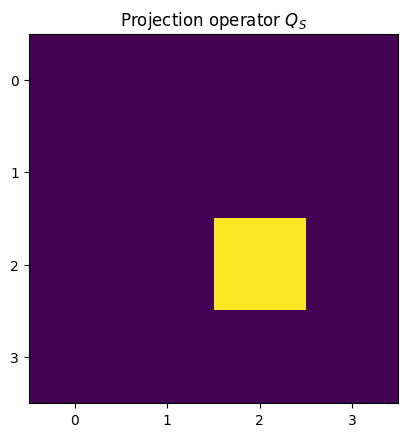

In [4]:
# Clear nuclei temporally
_nuclei_tmp0 = sim.molecules[0].nuclei
_nuclei_tmp1 = sim.molecules[1].nuclei
sim.molecules[0].nuclei = []
sim.molecules[1].nuclei = []

# for Singlet-Triplet basis
sx_1 = sim.spin_operator(0, "x")
sy_1 = sim.spin_operator(0, "y")
sz_1 = sim.spin_operator(0, "z")
sx_2 = sim.spin_operator(1, "x")
sy_2 = sim.spin_operator(1, "y")
sz_2 = sim.spin_operator(1, "z")

Qs = sim.projection_operator(rp.simulation.State.SINGLET)
Qt = sim.projection_operator(rp.simulation.State.TRIPLET)

# Revert nuclei
sim.molecules[0].nuclei = _nuclei_tmp0
sim.molecules[1].nuclei = _nuclei_tmp1

plt.title("Projection operator $Q_S$")
plt.imshow(Qs.real)
plt.xticks([0, 1, 2, 3])
plt.yticks([0, 1, 2, 3])
plt.show()

## Define `OpSite` and coefficients

- RadicalPy uses Hz in energy unit but it is too large to keep numerical stabiltiy
- Thus, one will use GHz in energy unit
- For some reasons, extraction of imaginary unit of pauli y operator leads stable simulation for degenerate system (why??)

In [5]:
SCALE = 1.0e-09
gamma = [p.gamma_mT for p in sim.particles]

g_ele_sym = [
    Symbol(r"\gamma_e^{(" + f"{i + 1}" + ")}") for i in range(len(sim.radicals))
]
g_nuc_sym = {}
for i in range(len(sim.radicals)):
    for j in range(len(sim.molecules[i].nuclei)):
        g_nuc_sym[(i, j)] = Symbol(r"\gamma_n^{" + f"{(i + 1, j + 1)}" + "}")

subs = {}
for i, ge in enumerate(g_ele_sym):
    subs[ge] = sim.radicals[i].gamma_mT
for (i, j), gn in g_nuc_sym.items():
    subs[gn] = sim.molecules[i].nuclei[j].gamma_mT

Define radical spin operators

In [6]:
def get_OE(op):
    """
    OT ⊗ 𝟙
    """
    return np.kron(op.T, np.eye(op.shape[0], dtype=op.dtype))


def get_EO(op):
    """
    𝟙 ⊗ O
    """
    return np.kron(np.eye(op.shape[0], dtype=op.dtype), op)


ele_site = len(sim.molecules[0].nuclei)

SxE_ops = []
SyE_ops = []
SzE_ops = []
ESx_ops = []
ESy_ops = []
ESz_ops = []

S1S2E_op = OpSite(
    r"(\hat{S}_1\cdot\hat{S}_2)^\ast ⊗ 𝟙",
    ele_site,
    value=get_OE(sx_1 @ sx_2 + sy_1 @ sy_2 + sz_1 @ sz_2),
)
ES1S2_op = OpSite(
    r"𝟙 ⊗ (\hat{S}_1\cdot\hat{S}_2)",
    ele_site,
    value=get_EO(sx_1 @ sx_2 + sy_1 @ sy_2 + sz_1 @ sz_2),
)
EE_op = OpSite(
    r"\hat{E} ⊗ \hat{E}", ele_site, value=get_OE(np.eye(sx_1.shape[0]))
)

QsE_op = OpSite(r"\hat{Q}_S ⊗ 𝟙", ele_site, value=get_OE(Qs))
EQs_op = OpSite(r"𝟙 ⊗ \hat{Q}_S", ele_site, value=get_EO(Qs))
QtE_op = OpSite(r"\hat{Q}_T ⊗ 𝟙", ele_site, value=get_OE(Qt))
EQt_op = OpSite(r"𝟙 ⊗ \hat{Q}_T", ele_site, value=get_EO(Qt))


SxE_ops.append(OpSite(r"\hat{S}_x^{(1)\ast} ⊗ 𝟙", ele_site, value=get_OE(sx_1)))
SxE_ops.append(OpSite(r"\hat{S}_x^{(2)\ast} ⊗ 𝟙", ele_site, value=get_OE(sx_2)))
SyE_ops.append(OpSite(r"\hat{S}_y^{(1)\ast} ⊗ 𝟙", ele_site, value=get_OE(sy_1)))
SyE_ops.append(OpSite(r"\hat{S}_y^{(2)\ast} ⊗ 𝟙", ele_site, value=get_OE(sy_2)))
SzE_ops.append(OpSite(r"\hat{S}_z^{(1)\ast} ⊗ 𝟙", ele_site, value=get_OE(sz_1)))
SzE_ops.append(OpSite(r"\hat{S}_z^{(2)\ast} ⊗ 𝟙", ele_site, value=get_OE(sz_2)))

ESx_ops.append(OpSite(r"𝟙 ⊗ \hat{S}_x^{(1)}", ele_site, value=get_EO(sx_1)))
ESx_ops.append(OpSite(r"𝟙 ⊗ \hat{S}_x^{(2)}", ele_site, value=get_EO(sx_2)))
ESy_ops.append(OpSite(r"𝟙 ⊗ \hat{S}_y^{(1)}", ele_site, value=get_EO(sy_1)))
ESy_ops.append(OpSite(r"𝟙 ⊗ \hat{S}_y^{(2)}", ele_site, value=get_EO(sy_2)))
ESz_ops.append(OpSite(r"𝟙 ⊗ \hat{S}_z^{(1)}", ele_site, value=get_EO(sz_1)))
ESz_ops.append(OpSite(r"𝟙 ⊗ \hat{S}_z^{(2)}", ele_site, value=get_EO(sz_2)))

SrE_ops = [SxE_ops, SyE_ops, SzE_ops]
ESr_ops = [ESx_ops, ESy_ops, ESz_ops]

Define nuclear spin operators

In [7]:
IxE_ops = {}
IyE_ops = {}
IzE_ops = {}
EIx_ops = {}
EIy_ops = {}
EIz_ops = {}

for j, nuc in enumerate(sim.molecules[0].nuclei):
    val = nuc.pauli["x"]
    IxE_ops[(0, j)] = OpSite(
        r"\hat{I}_x^{" + f"{(1, j + 1)}" + r"\ast} ⊗ 𝟙",
        j,
        value=get_OE(val),
    )
    EIx_ops[(0, j)] = OpSite(
        r"𝟙 ⊗ \hat{I}_x^{" + f"{(1, j + 1)}" + "}",
        j,
        value=get_EO(val),
    )
    val = nuc.pauli["y"]
    IyE_ops[(0, j)] = OpSite(
        r"\hat{I}_y^{" + f"{(1, j + 1)}" + r"\ast} ⊗ 𝟙",
        j,
        value=get_OE(val),
    )
    EIy_ops[(0, j)] = OpSite(
        r"𝟙 ⊗ \hat{I}_y^{" + f"{(1, j + 1)}" + "}",
        j,
        value=get_EO(val),
    )
    val = nuc.pauli["z"]
    IzE_ops[(0, j)] = OpSite(
        r"\hat{I}_z^{" + f"{(1, j + 1)}" + r"\ast} ⊗ 𝟙",
        j,
        value=get_OE(val),
    )
    EIz_ops[(0, j)] = OpSite(
        r"𝟙 ⊗ \hat{I}_z^{" + f"{(1, j + 1)}" + "}",
        j,
        value=get_EO(val),
    )

for j, nuc in enumerate(sim.molecules[1].nuclei):
    site = ele_site + 1 + j
    val = nuc.pauli["x"]
    IxE_ops[(1, j)] = OpSite(
        r"\hat{I}_x^{" + f"{(2, j + 1)}" + r"\ast} ⊗ 𝟙",
        site,
        value=get_OE(val),
    )
    EIx_ops[(1, j)] = OpSite(
        r"𝟙 ⊗ \hat{I}_x^{" + f"{(2, j + 1)}" + "}",
        site,
        value=get_EO(val),
    )
    val = nuc.pauli["y"]
    IyE_ops[(1, j)] = OpSite(
        r"\hat{I}_y^{" + f"{(2, j + 1)}" + r"\ast} ⊗ 𝟙",
        site,
        value=get_OE(val),
    )
    EIy_ops[(1, j)] = OpSite(
        r"𝟙 ⊗ \hat{I}_y^{" + f"{(2, j + 1)}" + "}",
        ele_site + 1 + j,
        value=get_EO(val),
    )
    val = nuc.pauli["z"]
    IzE_ops[(1, j)] = OpSite(
        r"\hat{I}_z^{" + f"{(2, j + 1)}" + r"\ast} ⊗ 𝟙",
        site,
        value=get_OE(val),
    )
    EIz_ops[(1, j)] = OpSite(
        r"𝟙 ⊗ \hat{I}_z^{" + f"{(2, j + 1)}" + "}",
        site,
        value=get_EO(val),
    )

IrE_ops = [IxE_ops, IyE_ops, IzE_ops]
EIr_ops = [EIx_ops, EIy_ops, EIz_ops]

## Hyperfine coupling Hamiltonian
$$
\hat{H}_{\text{H}} = |\gamma_e|\sum_i \sum_j \hat{S}_i^\top\cdot A_{ij}\cdot \hat{I}_{ij}
$$

In [8]:
hyperfine = SumOfProducts()

xyz = "xyz"

for i in range(len(sim.radicals)):
    for j in range(len(sim.molecules[i].nuclei)):
        for k, (SrE_op, ESr_op) in enumerate(
            zip(SrE_ops, ESr_ops, strict=True)
        ):
            for l, (IrE_op, EIr_op) in enumerate(
                zip(IrE_ops, EIr_ops, strict=True)
            ):
                if A[(i, j)][k, l] == 0.0:
                    continue
                Asym = Symbol(
                    "A^{"
                    + f"{(i + 1, j + 1)}"
                    + "}_{"
                    + f"{xyz[k]}"
                    + f"{xyz[l]}"
                    + "}"
                )
                subs[Asym] = A[(i, j)][k, l].item() * SCALE
                hyperfine -= (
                    Asym * abs(g_ele_sym[0]) * SrE_op[i] * IrE_op[(i, j)]
                )
                hyperfine += (
                    Asym * abs(g_ele_sym[0]) * ESr_op[i] * EIr_op[(i, j)]
                )

In [9]:
hyperfine = hyperfine.simplify()
hyperfine.symbol

-A^{(1, 1)}_{xx}*Abs(\gamma_e^{(1)})*\hat{I}_x^{(1, 1)\ast} ⊗ 𝟙*\hat{S}_x^{(1)\ast} ⊗ 𝟙 + A^{(1, 1)}_{xx}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{I}_x^{(1, 1)}*𝟙 ⊗ \hat{S}_x^{(1)} - A^{(1, 1)}_{yy}*Abs(\gamma_e^{(1)})*\hat{I}_y^{(1, 1)\ast} ⊗ 𝟙*\hat{S}_y^{(1)\ast} ⊗ 𝟙 + A^{(1, 1)}_{yy}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{I}_y^{(1, 1)}*𝟙 ⊗ \hat{S}_y^{(1)} - A^{(1, 1)}_{zz}*Abs(\gamma_e^{(1)})*\hat{I}_z^{(1, 1)\ast} ⊗ 𝟙*\hat{S}_z^{(1)\ast} ⊗ 𝟙 + A^{(1, 1)}_{zz}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{I}_z^{(1, 1)}*𝟙 ⊗ \hat{S}_z^{(1)} - A^{(2, 1)}_{xx}*Abs(\gamma_e^{(1)})*\hat{S}_x^{(2)\ast} ⊗ 𝟙*\hat{I}_x^{(2, 1)\ast} ⊗ 𝟙 + A^{(2, 1)}_{xx}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{S}_x^{(2)}*𝟙 ⊗ \hat{I}_x^{(2, 1)} - A^{(2, 1)}_{yy}*Abs(\gamma_e^{(1)})*\hat{S}_y^{(2)\ast} ⊗ 𝟙*\hat{I}_y^{(2, 1)\ast} ⊗ 𝟙 + A^{(2, 1)}_{yy}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{S}_y^{(2)}*𝟙 ⊗ \hat{I}_y^{(2, 1)} - A^{(2, 1)}_{zz}*Abs(\gamma_e^{(1)})*\hat{S}_z^{(2)\ast} ⊗ 𝟙*\hat{I}_z^{(2, 1)\ast} ⊗ 𝟙 + A^{(2, 1)}_{zz}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{S}_z^{(2)}*𝟙 ⊗ 

## Zeeman Hamiltonian
$$
\hat{H}_{\text{Z}}
= - \vec{B} \cdot \sum_i \left(\gamma_{\text{e}}\vec{S}^{(i)} + \left(\sum_j\gamma_{\text{n}}^{(ij)}\vec{I}^{(ij)}\right)\right)
$$

In [10]:
zeeman = SumOfProducts()

xyz = "xyz"

for k, (SrE_op, ESr_op, IrE_op, EIr_op) in enumerate(
    zip(SrE_ops, ESr_ops, IrE_ops, EIr_ops, strict=True)
):
    if B[k] == 0.0:
        continue
    r = xyz[k]
    Br = Symbol(f"B_{r}")
    subs[Br] = B[k] * SCALE
    for i in range(len(sim.radicals)):
        zeeman += -Br * g_ele_sym[i] * ESr_op[i]
        zeeman += Br * g_ele_sym[i] * SrE_op[i]
        for j in range(len(sim.molecules[i].nuclei)):
            zeeman += -Br * g_nuc_sym[(i, j)] * EIr_op[(i, j)]
            zeeman += Br * g_nuc_sym[(i, j)] * IrE_op[(i, j)]

zeeman = zeeman.simplify()
zeeman.symbol

B_z*\gamma_e^{(1)}*\hat{S}_z^{(1)\ast} ⊗ 𝟙 - B_z*\gamma_e^{(1)}*𝟙 ⊗ \hat{S}_z^{(1)} + B_z*\gamma_e^{(2)}*\hat{S}_z^{(2)\ast} ⊗ 𝟙 - B_z*\gamma_e^{(2)}*𝟙 ⊗ \hat{S}_z^{(2)} + B_z*\gamma_n^{(1, 1)}*\hat{I}_z^{(1, 1)\ast} ⊗ 𝟙 - B_z*\gamma_n^{(1, 1)}*𝟙 ⊗ \hat{I}_z^{(1, 1)} + B_z*\gamma_n^{(2, 1)}*\hat{I}_z^{(2, 1)\ast} ⊗ 𝟙 - B_z*\gamma_n^{(2, 1)}*𝟙 ⊗ \hat{I}_z^{(2, 1)}

## Exchange Hamiltonian
$$
\hat{H}_{\text{J}}
= -J |\gamma_e| \left(\vec{S}_1^\top\cdot\vec{S_2}+\frac{1}{2}\hat{E}\right)
$$

In [11]:
exchange = SumOfProducts()
if J != 0.0:
    Jsym = Symbol("J")
    subs[Jsym] = J * SCALE
    exchange += -Jsym * abs(g_ele_sym[0]) * (2 * ES1S2_op + 0.5 * EE_op)
    exchange -= -Jsym * abs(g_ele_sym[0]) * (2 * S1S2E_op + 0.5 * EE_op)
    exchange = exchange.simplify()
exchange.symbol

2*J*Abs(\gamma_e^{(1)})*(\hat{S}_1\cdot\hat{S}_2)^\ast ⊗ 𝟙 - 2*J*Abs(\gamma_e^{(1)})*𝟙 ⊗ (\hat{S}_1\cdot\hat{S}_2)

## Dipolar Hamiltonian
$$
\hat{H}_{\text{J}}
= |\gamma_e| \vec{S}_1^\top \cdot D \cdot \vec{S_2}
$$

In [12]:
dipolar = SumOfProducts()
for k in range(3):
    for l in range(3):
        if D[k, l] == 0.0:
            continue
        else:
            Dsym = Symbol("D_{" + f"{xyz[k]}" + f"{xyz[l]}" + "}")
            subs[Dsym] = D[k, l] * SCALE
            dipolar += Dsym * abs(g_ele_sym[0]) * ESr_ops[k][0] * ESr_ops[l][1]
            dipolar -= Dsym * abs(g_ele_sym[0]) * SrE_ops[k][0] * SrE_ops[l][1]
dipolar = dipolar.simplify()
dipolar.symbol

-D_{xx}*Abs(\gamma_e^{(1)})*\hat{S}_x^{(1)\ast} ⊗ 𝟙*\hat{S}_x^{(2)\ast} ⊗ 𝟙 + D_{xx}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{S}_x^{(1)}*𝟙 ⊗ \hat{S}_x^{(2)} - D_{yy}*Abs(\gamma_e^{(1)})*\hat{S}_y^{(1)\ast} ⊗ 𝟙*\hat{S}_y^{(2)\ast} ⊗ 𝟙 + D_{yy}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{S}_y^{(1)}*𝟙 ⊗ \hat{S}_y^{(2)} - D_{zz}*Abs(\gamma_e^{(1)})*\hat{S}_z^{(1)\ast} ⊗ 𝟙*\hat{S}_z^{(2)\ast} ⊗ 𝟙 + D_{zz}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{S}_z^{(1)}*𝟙 ⊗ \hat{S}_z^{(2)}

## Haberkorn relaxation

$$
i\hbar \frac{d}{dt} \rho = [H, \rho] - \sum_{i\in\{S, T\}}\frac{i\hbar k_i}{2}\{Q_i, \rho\} 
$$

The superoperator for vectorised form density matrix is 
$$
Q_i \otimes \mathbb{1} +  \mathbb{1} \otimes Q_i
$$

In [13]:
haberkorn = SumOfProducts()
if kS != 0.0:
    kSsym = Symbol("k_S")
    subs[kSsym] = kS * SCALE
    haberkorn -= 1.0j * kSsym / 2 * (QsE_op + EQs_op)
if kT != 0.0:
    kTsym = Symbol("k_T")
    subs[kTsym] = kT * SCALE
    haberkorn -= 1.0j * kTsym / 2 * (QtE_op + EQt_op)
haberkorn = haberkorn.simplify()
haberkorn.symbol

-0.5*I*k_S*(\hat{Q}_S ⊗ 𝟙 + 𝟙 ⊗ \hat{Q}_S) - 0.5*I*k_T*(\hat{Q}_T ⊗ 𝟙 + 𝟙 ⊗ \hat{Q}_T)

Construct matrix product operator (MPO) for MPS propagation

In [14]:
L = hyperfine + zeeman + exchange + dipolar + haberkorn
L = L.simplify()
am = AssignManager(L)
_ = am.assign()
# display(*am.Wsym)
mpo = am.numerical_mpo(subs=subs)
L.symbol

-A^{(1, 1)}_{xx}*Abs(\gamma_e^{(1)})*\hat{I}_x^{(1, 1)\ast} ⊗ 𝟙*\hat{S}_x^{(1)\ast} ⊗ 𝟙 + A^{(1, 1)}_{xx}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{I}_x^{(1, 1)}*𝟙 ⊗ \hat{S}_x^{(1)} - A^{(1, 1)}_{yy}*Abs(\gamma_e^{(1)})*\hat{I}_y^{(1, 1)\ast} ⊗ 𝟙*\hat{S}_y^{(1)\ast} ⊗ 𝟙 + A^{(1, 1)}_{yy}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{I}_y^{(1, 1)}*𝟙 ⊗ \hat{S}_y^{(1)} - A^{(1, 1)}_{zz}*Abs(\gamma_e^{(1)})*\hat{I}_z^{(1, 1)\ast} ⊗ 𝟙*\hat{S}_z^{(1)\ast} ⊗ 𝟙 + A^{(1, 1)}_{zz}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{I}_z^{(1, 1)}*𝟙 ⊗ \hat{S}_z^{(1)} - A^{(2, 1)}_{xx}*Abs(\gamma_e^{(1)})*\hat{S}_x^{(2)\ast} ⊗ 𝟙*\hat{I}_x^{(2, 1)\ast} ⊗ 𝟙 + A^{(2, 1)}_{xx}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{S}_x^{(2)}*𝟙 ⊗ \hat{I}_x^{(2, 1)} - A^{(2, 1)}_{yy}*Abs(\gamma_e^{(1)})*\hat{S}_y^{(2)\ast} ⊗ 𝟙*\hat{I}_y^{(2, 1)\ast} ⊗ 𝟙 + A^{(2, 1)}_{yy}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{S}_y^{(2)}*𝟙 ⊗ \hat{I}_y^{(2, 1)} - A^{(2, 1)}_{zz}*Abs(\gamma_e^{(1)})*\hat{S}_z^{(2)\ast} ⊗ 𝟙*\hat{I}_z^{(2, 1)\ast} ⊗ 𝟙 + A^{(2, 1)}_{zz}*Abs(\gamma_e^{(1)})*𝟙 ⊗ \hat{S}_z^{(2)}*𝟙 ⊗ 

## Liouville simulation

In [15]:
backend = "numpy"  # or "jax"  for large bond dimension and GPU
m = 32  # Bond dimension
Δt = 5.0e-10 / SCALE * units.au_in_fs  # dt = 0.5 ns

In [16]:
basis = []
for nuc in sim.molecules[0].nuclei:
    basis.append(Exciton(nstate=nuc.multiplicity**2))
basis.append(Exciton(nstate=4**2))
for nuc in sim.molecules[1].nuclei:
    basis.append(Exciton(nstate=nuc.multiplicity**2))
nsite = len(basis)

In [17]:
def singlet_state():
    hp = []
    for isite in range(nsite):
        if isite == ele_site:
            op = Qs
        else:
            # Mixed states !
            op = np.eye(isqrt(basis[isite].nstate))
        # Automatically nomarized so that trace=1 in internal code
        hp.append(op.reshape(-1).tolist())
    return hp


def process(mpo):
    operators = {"hamiltonian": mpo}
    model = Model(basis, operators=operators, space="Liouville", bond_dim=m)
    hp = singlet_state()
    model.init_HartreeProduct = [hp]

    jobname = "radicalpair_liouville"
    simulator = Simulator(
        jobname=jobname,
        model=model,
        backend=backend,
        verbose=0,
    )
    # Initiate the propagation setting with maxstep=0
    nstep = 100
    ener, wf = simulator.propagate(
        reduced_density=(
            [(ele_site, ele_site)],
            2,
        ),
        maxstep=nstep + 1,
        stepsize=Δt,
        autocorr=False,
        energy=False,
        norm=False,
        populations=False,
        observables=True,
        integrator="arnoldi",  # Since non-Hermitian
    )
    data = read_nc(f"{jobname}_prop/reduced_density.nc", [(ele_site, ele_site)])
    time_data = data["time"]
    density_data = data[(ele_site, ele_site)]
    return density_data, time_data

Since nuclear spins are mixed state, one needs to consider ensemble of nuclear spin initial states. 

In [18]:
dm, time_data = process(mpo)
time_data_μs = time_data * SCALE * 1e06 / units.au_in_fs

15:36:14 | INFO | Wave function is saved in wf_radicalpair_liouville.pkl
15:36:14 | INFO | The time unit in the netCDF file is fs
15:36:14 | INFO | Start initial step    0.000 [fs]


  0%|          | 0/101 [00:00<?, ?it/s]

15:36:14 | INFO | End     0 step; propagated    0.012 [fs]; AVG Krylov iteration: 5.67
15:36:15 | INFO | End   100 step; propagated    1.209 [fs]; AVG Krylov iteration: 5.67
15:36:15 | INFO | End simulation and save wavefunction
15:36:15 | INFO | Wave function is saved in wf_radicalpair_liouville.pkl


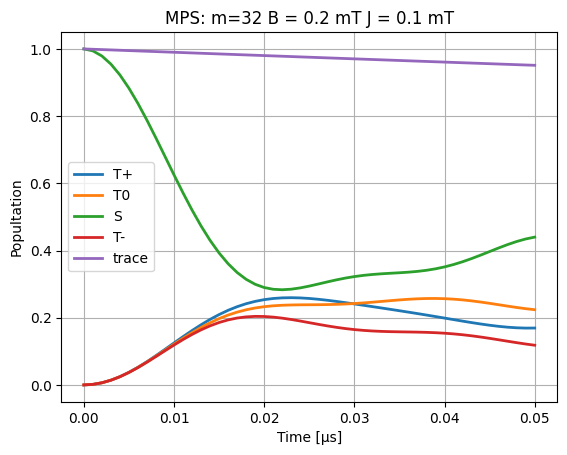

In [19]:
plt.plot(time_data_μs, dm[:, 0, 0].real, linewidth=2, label="T+")
plt.plot(time_data_μs, dm[:, 1, 1].real, linewidth=2, label="T0")
plt.plot(time_data_μs, dm[:, 2, 2].real, linewidth=2, label="S")
plt.plot(time_data_μs, dm[:, 3, 3].real, linewidth=2, label="T-")
plt.plot(time_data_μs, np.einsum("ijj->i", dm.real), linewidth=2, label="trace")
plt.title(f"MPS: {m=} B = {B0} mT J = {J} mT")
plt.legend()
plt.xlabel("Time [μs]")
plt.ylabel("Popultation")
plt.grid()
# plt.ylim([0, 1])
plt.savefig("population.png")
plt.show()

/Users/hinom/GitHub/PyTDSCF/.venv/lib/python3.12/site-packages/scipy/linalg/_matfuncs.py:202: LogmExactlySingularWarning: The logm input matrix is exactly singular.
  F = scipy.linalg._matfuncs_inv_ssq._logm(A)
/var/folders/sj/nm7r7k8969b31b686cw52trh0000gn/T/ipykernel_29482/1577440271.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


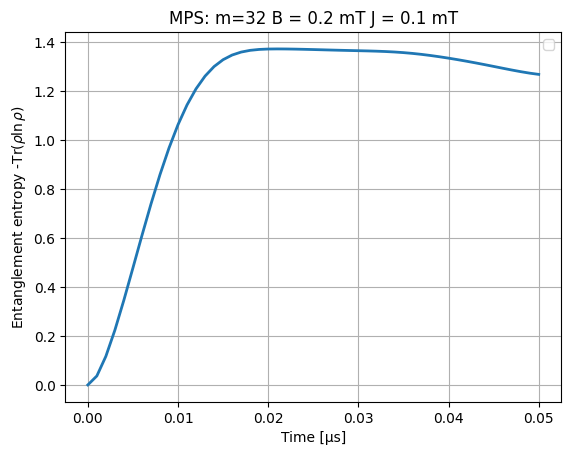

In [20]:
from scipy.linalg import logm

plt.plot(
    time_data_μs,
    [-np.trace(rho * logm(rho)).real for rho in dm],
    linewidth=2,
    label="",
)

plt.title(f"MPS: {m=} B = {B0} mT J = {J} mT")
plt.legend()
plt.xlabel("Time [μs]")
plt.ylabel(r"Entanglement entropy -Tr($\rho \ln \rho$)")
plt.grid()
plt.show()

Saving animation to rdm-radical.gif...
Animation saved successfully!


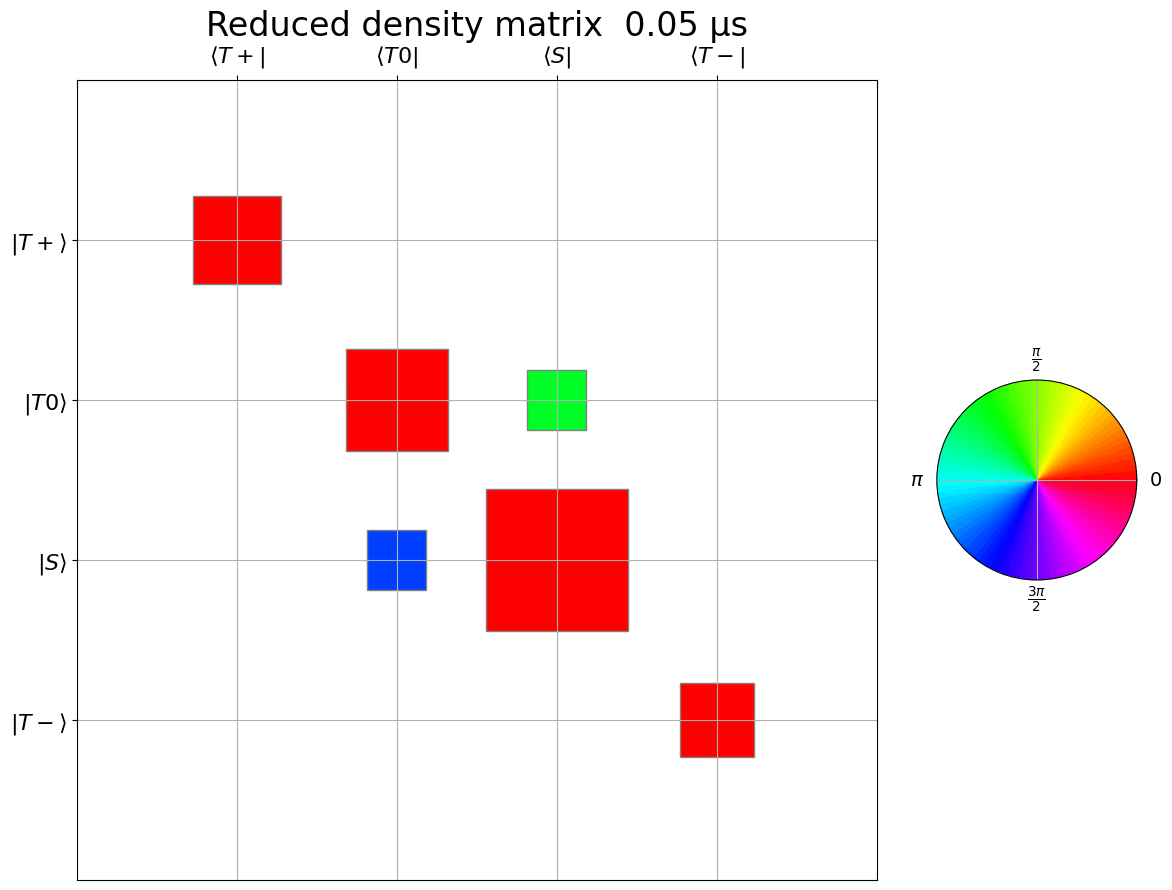

In [21]:
# Note: spin coherent state sampling has slower convergence for off-diagnal term than projection state sampling
fig, anim = get_anim(
    dm[::2, :, :],
    time_data_μs[::2],
    title="Reduced density matrix",
    time_unit="μs",
    save_gif=True,
    dpi=30,
    gif_filename="rdm-radical.gif",
    row_names=[
        r"$|T+\rangle$",
        r"$|T0\rangle$",
        r"$|S\rangle$",
        r"$|T-\rangle$",
    ],
    col_names=[
        r"$\langle T+|$",
        r"$\langle T0|$",
        r"$\langle S|$",
        r"$\langle T-|$",
    ],
)
plt.show()
HTML(anim.to_jshtml())

## Compare with RadicalPy simulation

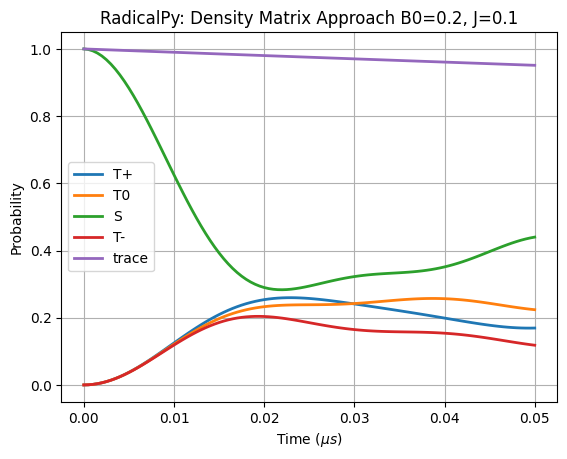

In [22]:
if len(basis) < 6:
    assert isinstance(D, np.ndarray)
    H = sim.total_hamiltonian(B0=B0, D=D, J=J)
    time = np.arange(0, 5.0e-8 + 5e-10, 5e-10)
    kinetics = [
        rp.kinetics.Haberkorn(kS, rp.simulation.State.SINGLET),
        rp.kinetics.Haberkorn(kT, rp.simulation.State.TRIPLET),
    ]
    sim.apply_liouville_hamiltonian_modifiers(H, kinetics)
    rhos = sim.time_evolution(State.SINGLET, time, H)

    time_evol_s = sim.product_probability(State.SINGLET, rhos)
    time_evol_tp = sim.product_probability(State.TRIPLET_PLUS, rhos)
    time_evol_tz = sim.product_probability(State.TRIPLET_ZERO, rhos)
    time_evol_tm = sim.product_probability(State.TRIPLET_MINUS, rhos)
    x = time * 1e6

    plt.plot(x, time_evol_tp, linewidth=2, label="T+")
    plt.plot(x, time_evol_tz, linewidth=2, label="T0")
    plt.plot(x, time_evol_s, linewidth=2, label="S")
    plt.plot(x, time_evol_tm, linewidth=2, label="T-")
    plt.plot(
        x,
        time_evol_tp + time_evol_tz + time_evol_s + time_evol_tm,
        linewidth=2,
        label="trace",
    )
    plt.legend()
    plt.title(f"RadicalPy: Density Matrix Approach {B0=}, {J=}")
    plt.xlabel(r"Time ($\mu s$)")
    plt.ylabel("Probability")
    # plt.ylim([0, 1])
    plt.grid()
    plt.show()

    rhos = rhos.reshape(
        rhos.shape[0], isqrt(rhos.shape[1]), isqrt(rhos.shape[1])
    )

In [23]:
# Clean files
!rm -rf radicalpair_*_prop
!rm -f wf_radicalpair_*.pkl